In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from scipy.stats import linregress
from sklearn.model_selection import train_test_split


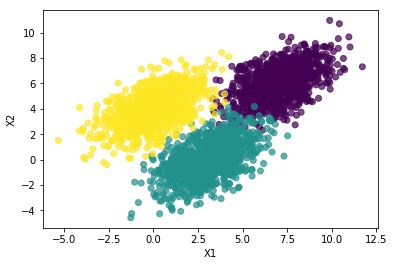

In [3]:
np.random.seed(10)
A = np.random.multivariate_normal([7, 6], [[2, 1],[1, 2]], 1000)
B = np.random.multivariate_normal([3, 0], [[2, 1],[1, 2]], 1000)
C = np.random.multivariate_normal([0, 4], [[2, 1],[1, 2]], 1000)
X = np.concatenate((A, B, C))
y = np.concatenate((np.array(["A" for i in range(A.shape[0])]), 
                    np.array(["B" for i in range(B.shape[0])]), 
                    np.array(["C" for i in range(C.shape[0])])))
cm = y.copy()
cm[cm == "A"] = 1
cm[cm == "B"] =2
cm[cm =="C"] =3
plt.figure()
plt.scatter(np.array([i[0] for i in X]), np.array([i[1] for i in X]), c = cm, alpha = 0.7)
#plt.scatter(*np.hsplit(X, 2), c = y)
plt.xlabel("X1")
plt.ylabel("X2")
plt.show()

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 1)
mpl = MLPClassifier(activation = "logistic", solver = "sgd", max_iter=500,alpha=0.0001, shuffle = True)
mpl = mpl.fit(X_train,y_train)
mpl.score(X_test, y_test)


0.98333333333333328

array([ 0.,  0.,  0.])

In [48]:
class Neural_network():
       def __init__(self, X = np.array, y = np.array, hidden_layer_size  = tuple, alpha = float, num_iter = int):
            self.X = X
            # each element in y needs to be converted into the representative vector to allow computation
            unique_class = np.unique(y).tolist()
            converted_output = []
            for label in y:
                output_vector = np.zeros(np.unique(y).size)
                index_num = unique_class.index(label)
                output_vector[index_num] = 1
                converted_output.append(output_vector)
            self.y = np.array(converted_output)            
            self.alpha = alpha
            self.num_iter = num_iter
            self.num_layer = len(hidden_layer_size) + 2
            # initialise the weight matrix here
            # the weight matrix of each layer is stored as elements inside a list
            # there should be (len(whole_network_size) - 1) number of weight matx
            self.weights = []
            
            whole_network_size = (X.shape[1],) + hidden_layer_size + (number_of_output,)
            for i in range(len(whole_network_size) - 1):
                # the weight is a N x M matrix, where N is number of unit in the next layer, and M is the number of unit of \ 
                # current layer + 1 bias unit
                ############## initial weight shouldn't be zero#############
                weight = np.zeros((whole_network_size[i+1].shape[0], whole_network_size[i].shape[0] + 1))
                self.weights.append(weight)
        def sigmoid(self, z = np.array):
            h = 1/(1+np.exp(-z))
            return h
        def forward_propagation():
            #for now only use sigmoid function for activation
            # start off with the features (X) as the first layer input (with bias unit)
            # forward propagation compute the sigmoid output of the dot product of Wi and ai.
            # the output of that would be the next layer input 
            # current_input is a N x M matrix, where N is the number of features and M is the number of examples
            current_input = np.concatenate(np.ones(self.X.shape[0]), self.X).T
            for i in range(len(whole_network_size) -1):
                z = np.dot(self.weights[i], current_input)
                h = self.sigmoid(z)
                current_input = h
        def backward_propagation():
                       

array(['A', 'A', 'A', ..., 'C', 'C', 'C'],
      dtype='<U1')

In [25]:
unique_class = np.unique(y).tolist()
converted_output = []
for label in y:
    output_vector = np.zeros(np.unique(y).size)
    index_num = unique_class.index(label)
    output_vector[index_num] = 1
    converted_output.append(output_vector)
y_new = np.array(converted_output)

In [26]:
y_new

array([[ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       ..., 
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.]])